In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import *
# from imblearn.metrics import specificity_score

In [3]:
# from imblearn.combine import SMOTETomek
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import OneSidedSelection
# from imblearn.under_sampling import TomekLinks

In [4]:
# import time
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [5]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

### Getting Data

In [6]:
res = pd.read_csv('../Outputs/resampled_cat.csv', encoding='cp949', index_col=0)
test = pd.read_csv('../Outputs/test_set_cat.csv', encoding='cp949', index_col=0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [7]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1] 
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [9]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 50, 600),
        'learning_rate':trial.suggest_float('learning_rate', 0.0005, 0.3),
        'depth':trial.suggest_int('depth', 3, 12),
    }
    
    cat_model = CatBoostClassifier(**params, cat_features=['인접도로구분', '브랜드'],
                                   verbose=0, eval_metric='AUC', random_state=42)
    cat_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred_prob = cat_model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_prob)                                               
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [10]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=20)

[I 2024-06-06 22:24:47,370] A new study created in memory with name: no-name-8b07ca4a-a749-45a3-8dea-5a616b4b002d
[I 2024-06-06 22:27:13,750] Trial 0 finished with value: 0.6028568648232911 and parameters: {'n_estimators': 144, 'learning_rate': 0.22999506970461375, 'depth': 12}. Best is trial 0 with value: 0.6028568648232911.
[I 2024-06-06 22:28:27,077] Trial 1 finished with value: 0.6072434015532377 and parameters: {'n_estimators': 328, 'learning_rate': 0.22183357586069352, 'depth': 7}. Best is trial 1 with value: 0.6072434015532377.
[I 2024-06-06 22:28:57,136] Trial 2 finished with value: 0.605233595332783 and parameters: {'n_estimators': 156, 'learning_rate': 0.15514791120777452, 'depth': 7}. Best is trial 1 with value: 0.6072434015532377.
[I 2024-06-06 22:30:07,146] Trial 3 finished with value: 0.6044594150971712 and parameters: {'n_estimators': 208, 'learning_rate': 0.11577721580524016, 'depth': 9}. Best is trial 1 with value: 0.6072434015532377.
[I 2024-06-06 22:30:54,650] Trial 

In [11]:
cat_model = CatBoostClassifier(**study.best_params, cat_features=['인접도로구분', '브랜드'],
                               eval_metric='AUC', random_state=42)
cat_model.fit(X_res, y_res)

0:	total: 99.7ms	remaining: 39.8s
1:	total: 204ms	remaining: 40.6s
2:	total: 326ms	remaining: 43.1s
3:	total: 495ms	remaining: 49s
4:	total: 630ms	remaining: 49.8s
5:	total: 762ms	remaining: 50s
6:	total: 873ms	remaining: 49s
7:	total: 1.08s	remaining: 53.1s
8:	total: 1.22s	remaining: 52.9s
9:	total: 1.35s	remaining: 52.9s
10:	total: 1.48s	remaining: 52.2s
11:	total: 1.57s	remaining: 50.9s
12:	total: 1.7s	remaining: 50.5s
13:	total: 1.84s	remaining: 50.7s
14:	total: 1.97s	remaining: 50.5s
15:	total: 2.04s	remaining: 49.1s
16:	total: 2.15s	remaining: 48.5s
17:	total: 2.27s	remaining: 48.2s
18:	total: 2.39s	remaining: 48s
19:	total: 2.51s	remaining: 47.7s
20:	total: 2.63s	remaining: 47.5s
21:	total: 2.78s	remaining: 47.7s
22:	total: 2.97s	remaining: 48.8s
23:	total: 3.12s	remaining: 48.9s
24:	total: 3.34s	remaining: 50.1s
25:	total: 3.46s	remaining: 49.8s
26:	total: 3.56s	remaining: 49.2s
27:	total: 3.71s	remaining: 49.4s
28:	total: 3.84s	remaining: 49.1s
29:	total: 3.96s	remaining: 48.9

### Making Predictions

In [12]:
y_pred = cat_model.predict(X_test)
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]

### Plotting and Metrics

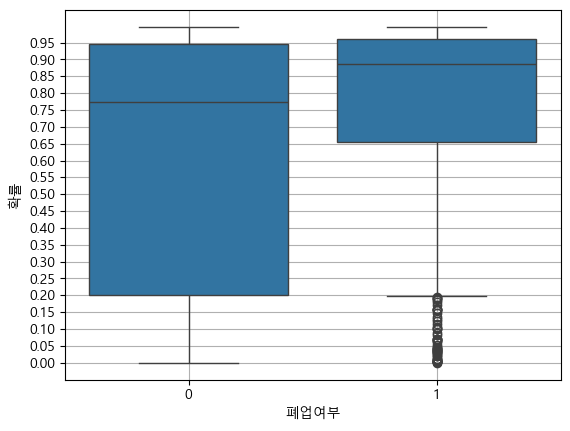

In [19]:
# Plotting Probabilities
temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp)
plt.grid(True)
plt.yticks(np.arange(0, 1, 0.05))
plt.show()

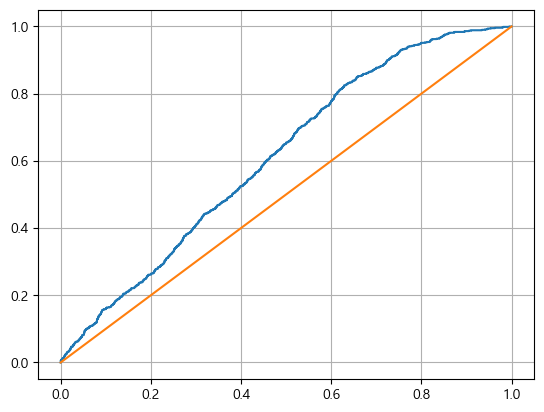

In [20]:
# AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC'),
plt.plot([0, 1], [0, 1])
plt.grid()
plt.show()

In [24]:
threshold = 0.82
y_pred = y_pred = (y_pred_prob >= threshold).astype(int)

In [25]:
# Metrics
cm = confusion_matrix(y_test, y_pred)
print("0-1 proportion at test set :", y_test.value_counts().values)
print("accuracy score :", accuracy_score(y_test, y_pred))
# print("precision score :", precision_score(y_test, y_pred))
# print("specificity :", specificity_score(y_test, y_pred))
print("recall score :", recall_score(y_test, y_pred))
print("f1_score :", f1_score(y_test, y_pred))
print("AUC score :", roc_auc_score(y_test, y_pred))

0-1 proportion at test set : [53308   800]
accuracy score : 0.5402343461225697
recall score : 0.60375
f1_score : 0.03737956119645552
AUC score : 0.5715155792751557


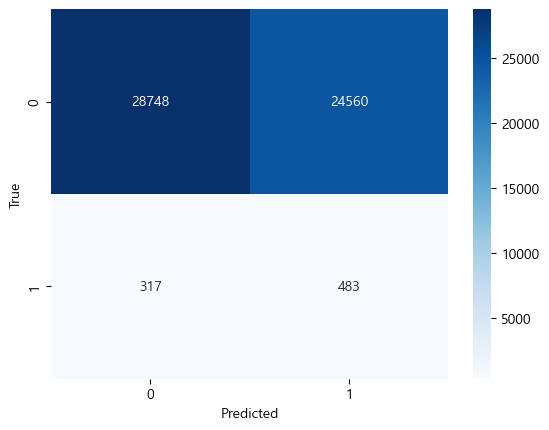

In [29]:
# Confusion Matrix
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

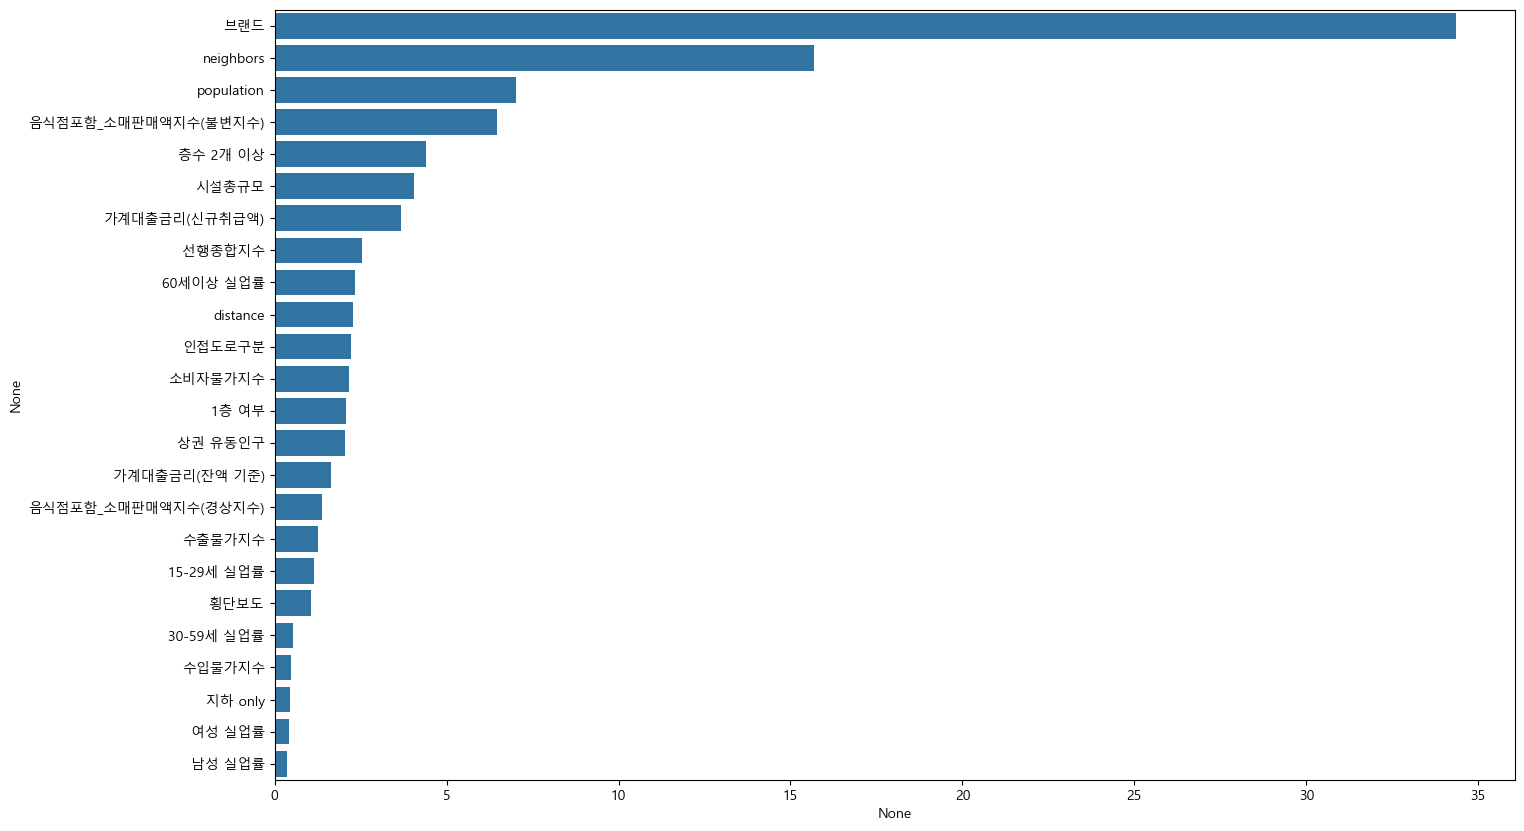

In [27]:
## Feature Importance
ser = pd.Series(cat_model.feature_importances_, index=X_res.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.show()